In [1]:
# Installing the Backtrader library
!pip install backtrader

In [2]:
# Importing the required packages
from __future__ import (absolute_import, division, print_function, unicode_literals)

import warnings
warnings.filterwarnings('ignore')

import datetime  # For datetime information
import os.path   # To manage paths
import sys       # To find out the script name (in argv[0])

import backtrader as bt  # Importing the Backtrader library

In [3]:
# Coding the Bollinger Bands strategy

class BBandStrategy(bt.Strategy):
    params = (('period', 30),('d_factor', 3.0),)
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a Bollinger Bands indicator
        self.bband = bt.indicators.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.d_factor)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        # Reset
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %(trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Check if an order is pending; if yes, then we cannot send a 2nd one
        if self.order:
            return
        # Check if we are in the market
        if not self.position:
            # if the close value is lower than Bollinger low: it is a buying opportunity
            if self.data.close < self.bband.lines.bot:
                # Let's go long (Buy)
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the already created order to avoid a 2nd order
                self.order = self.buy()
            # if the close value is greater than Bollinger high: it is a selling opportunity 
            elif self.data.close > self.bband.lines.top:
                # SELL, SELL, SELL!!! (Since we are not in market let's Short)
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the already created order to avoid a 2nd order
                self.order = self.sell()
        else:
            # exiting the long position; reaching the midline can be a good target
            if self.position.size>0 and self.data.close >= self.bband.lines.mid:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()
            # exiting the short position; reaching the midline can be a good target
            elif self.position.size<0 and self.data.close <= self.bband.lines.mid:
                #Buy
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the already created order to avoid a 2nd order
                self.order = self.close()

2003-09-02 SELL CREATE, 11.91
2003-09-03 SELL EXECUTED, Price: 12.21, Cost: -122.10, Comm 1.22
2003-09-17 BUY CREATE, 10.92
2003-09-18 BUY EXECUTED, Price: 10.91, Cost: -122.10, Comm 1.09
2003-09-18 OPERATION PROFIT, GROSS 13.00, NET 10.69
2004-09-15 SELL CREATE, 10.08
2004-09-16 SELL EXECUTED, Price: 10.01, Cost: -100.10, Comm 1.00
2004-11-22 BUY CREATE, 11.28
2004-11-23 BUY EXECUTED, Price: 11.21, Cost: -100.10, Comm 1.12
2004-11-23 OPERATION PROFIT, GROSS -12.00, NET -14.12
2004-12-13 SELL CREATE, 13.01
2004-12-14 SELL EXECUTED, Price: 12.86, Cost: -128.60, Comm 1.29
2005-01-04 BUY CREATE, 11.62
2005-01-05 BUY EXECUTED, Price: 11.59, Cost: -128.60, Comm 1.16
2005-01-05 OPERATION PROFIT, GROSS 12.70, NET 10.25
2005-06-29 SELL CREATE, 12.07
2005-06-30 SELL EXECUTED, Price: 12.06, Cost: -120.60, Comm 1.21
2005-08-03 BUY CREATE, 11.90
2005-08-04 BUY EXECUTED, Price: 11.79, Cost: -120.60, Comm 1.18
2005-08-04 OPERATION PROFIT, GROSS 2.70, NET 0.32
2005-09-23 BUY CREATE, 11.07
2005-09-26 

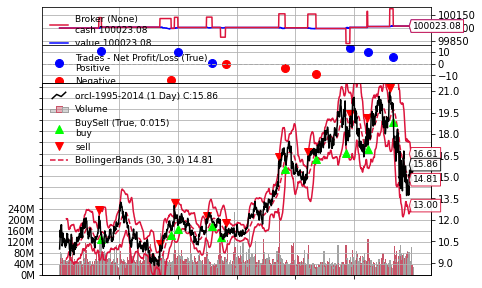

In [4]:
if __name__ == "__main__":
    cerebro = bt.Cerebro()
    data = bt.feeds.YahooFinanceCSVData(
        dataname = 'orcl-1995-2014.txt',
        # Do not pass values before this date
        fromdate=datetime.datetime(2003, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2008, 12, 31),
        reverse=False
    ) 
    
    # Add data
    cerebro.adddata(data)

    # Add strategy
    cerebro.addstrategy(BBandStrategy)

    # Fix the size
    cerebro.addsizer(bt.sizers.SizerFix, stake=10)

    # Initial investment
    cerebro.broker.setcash(100000.0)  

    # Some money for the broker
    cerebro.broker.setcommission(commission=0.01)

    start_portfolio_value = cerebro.broker.getvalue()

    cerebro.run()

    end_portfolio_value = cerebro.broker.getvalue()
    
    print("Starting portfolio value: %s \nEnding portfolio value: %s \nPnl: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))
    
    cerebro.plot(iplot=False) 